In [1]:
import sys
sys.path.insert(0, './auxiliary_functions/')
import single_cell_analysis as sc
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns
from scipy.stats.stats import pearsonr 
sns.set_style('white')
sns.set_context('notebook', font_scale=1.7, rc={'lines.linewidth': 1.3})
sns.despine()

#%matplotlib nbagg
%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.rcParams.update({'font.size': 16}) 

def pcorr(x,y, log_scale=False):
    if log_scale:
        x = np.log2(x)
        y = np.log2(y)
    [corr,p] = pearsonr(x, y)
    a,b   = np.polyfit(x, y, 1) 
    return [a, b, corr, p]

def get_expression(D):
    out = []
    for i in range(len(D['list_genes'])):
        out += [np.sum(D['data'].loc[D['list_genes'][i]].values, axis=0)]
    return np.log2(np.array(out)+1)

In [2]:
X1 = pd.read_csv('../data/BrainInjury_GSE67833_1.csv',  index_col=0,    header=0)
X2 = pd.read_csv('../data/BrainInjury_GSE67833_2.csv',  index_col=0,    header=0)
Xi = pd.read_csv('../data/BrainInjury_Ensembl_IDs.txt', index_col=None, header=0)

def gname(Xi, g):
    return [[Xi[Xi['WikiGene Name']==i]['Ensembl Gene ID'].values[0] for i in g[j]] for j in range(len(g))]

D = {}
D['data'] = pd.concat([X1, X2], axis=1, join='inner')

# ---------------- selecting only control NSCs and TAP cells ---------------------
cl = pd.DataFrame(index=['cl'], columns=D['data'].columns)
for i in cl.columns:
    if i[0] == 'N':
        cl[i] = 0.0
    elif i[0] == 't':
        cl[i] = 1.0

D['data']   = D['data'][cl.columns[cl.loc['cl']<=1]]
cl   = cl[cl.columns[cl.loc['cl']<=1]]

D['marker'] = np.array([str(i).replace('0.0','o').replace('1.0','>') for i in cl.values[0]])
# ---------------------------------------------------------------------------------
print 'Number of NSC  =', np.sum(cl.values==0.0)
print 'Number of tap  =', np.sum(cl.values==1.0)

D['data'].head()

Number of NSC  = 130
Number of tap  = 27


,N1,N11,N13,N17,N18,N2,N22,N23,N24,N25,...,tap62,tap61,tap60,tap59,tap58,tap56,tap55,tap54,tap50,tap49
ENSMUSG00000099985,0.000,0.000,0.038,0.00,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
ENSMUSG00000030105,16.498,0.000,0.089,0.00,63.615,0.068,312.755,88.253,76.513,0.000,...,58.356,64.274,115.027,0.000,94.013,137.899,74.606,91.661,101.311,139.724
ENSMUSG00000098001,0.509,0.252,0.051,0.43,0.264,0.361,0.168,0.122,0.190,0.327,...,0.940,0.486,1.629,0.135,0.498,0.893,0.305,0.000,0.591,0.327
ENSMUSG00000096054,0.000,0.511,0.000,0.00,0.000,0.090,0.042,3.288,0.000,57.626,...,0.097,0.045,0.092,0.000,0.000,0.045,0.000,0.000,0.357,0.187
ENSMUSG00000074445,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [3]:
l = {}
l['Hes']  = ['Hes1', 'Hes5']
l['NSC']  = ['Slc1a3', 'Nr2e1', 'Sox9','Vcam1']
l['Diff'] = ['Eomes', 'Sox11', 'Pcna']
l['Stat'] = ['Lifr','Il6st']
l['aNSC'] = ['Ascl1', 'Fos', 'Egr1', 'Sox4', 'Sox11']
l['IDs' ] = ['Id1', 'Id2', 'Id3', 'Id4']
l['Dll']  = ['Dll1', 'Dll3', 'Dll4']

number of TAP with Hes>2 =  10


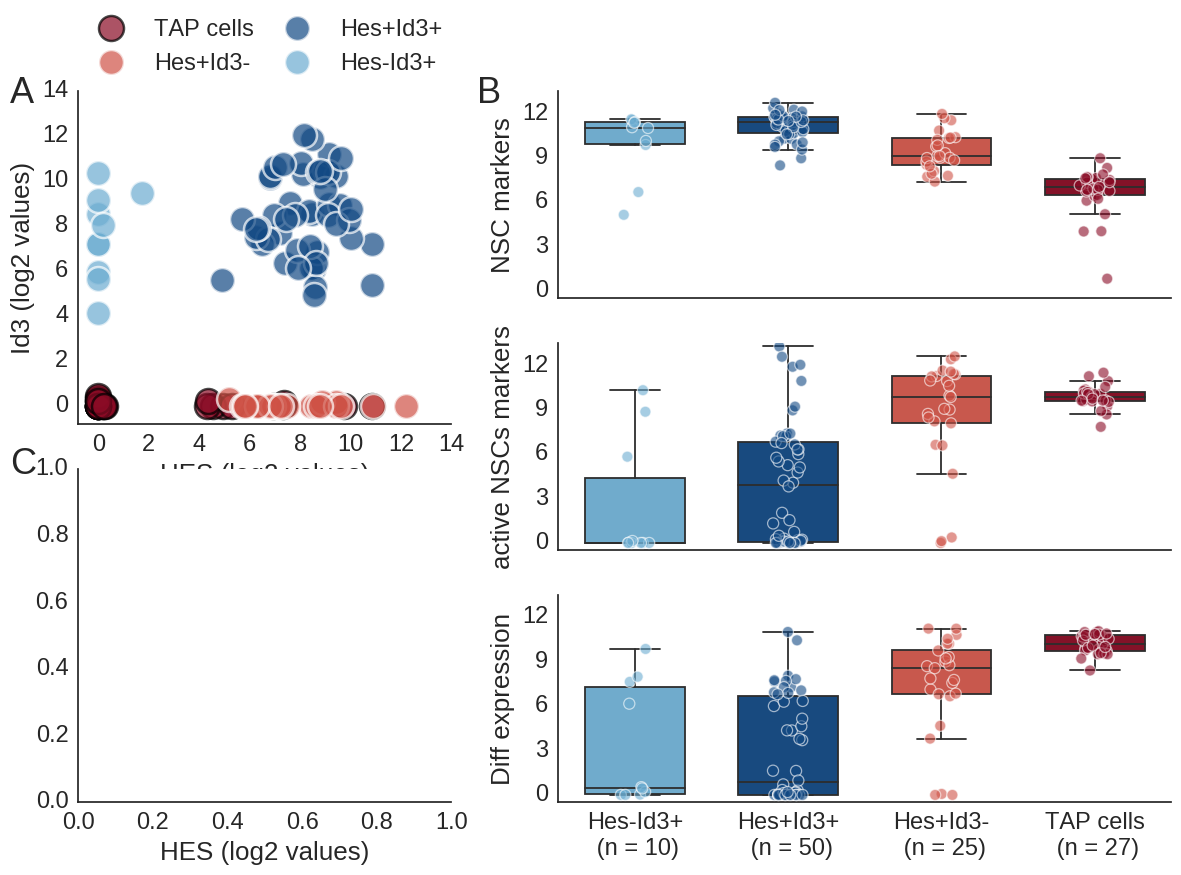

In [5]:
cmap=cm.get_cmap('RdBu_r')
f = plt.subplots(6, 5, figsize=(12, 8), sharex=True)
plt.tight_layout()
plt.subplots_adjust(wspace=0.8)
ax = plt.subplot2grid((6, 5), (0, 0), colspan=2, rowspan=3)
ax.text(-3.5, 13.5, 'A', fontsize=26)
ax.text(15.0, 13.5, 'B', fontsize=26)
ax.text(-3.5, -3.0, 'C', fontsize=26)

D['list_genes'] = gname(Xi,[l['Hes'], ['Id3'], l['NSC'], l['aNSC'], l['Diff']])
x = get_expression(D)

tr = 2    
t = [(x[0] < tr) & (x[1] > tr) & (D['marker']=='o'), (x[0] > tr) & (x[1] > tr) & (D['marker']=='o'), 
     (x[0] > tr) & (x[1] < tr) & (D['marker']=='o'), (D['marker']!='o')]
m     = ['o','o','o','o']
mec   = ['w','w','w','k']
c     = [cmap(0.25), cmap(0.05), cmap(0.82), cmap(0.95), 'y']
label = ['Hes-Id3+','Hes+Id3+','Hes+Id3-', 'TAP cells']

for i in np.arange(len(t)-1, -1, -1):
    plt.plot(x[0][t[i]], x[1][t[i]], marker=m[i], color=c[i], lw=0.0, mew=1.8, 
             mec=mec[i], ms=18, alpha=0.7, label=label[i])
    
print 'number of TAP with Hes>2 = ', np.sum(x[0][t[3]]>tr)
ax.set_xlabel('HES (log2 values)')
ax.set_ylabel('Id3 (log2 values)')
ax.set_xlim([-0.8,14])
ax.set_ylim([-0.8,14])
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)

ax = plt.subplot2grid((6, 5), (3, 0), colspan=2, rowspan=3)
ax.set_xlabel('HES (log2 values)')
ylim = [[-0.5,13.5], [-0.5,13.5], [-0.5,13.5]]
ylabel = ['NSC markers', 'active NSCs markers', 'Diff expression']
for i in range(3):
    ax = plt.subplot2grid((6, 5), (2*i, 2), colspan=3, rowspan=2)
    sns.boxplot(  data=[x[2+i][t[j]] for j in range(4)], palette=c, ax=ax,
                  saturation=0.9, width=0.65, fliersize=0)
    sns.stripplot(data=[x[2+i][t[j]] for j in range(4)], jitter=True, palette=c, size=8,
                  linewidth=0.9, edgecolor='w', marker='o', ax=ax, alpha=0.6)
    ax.set_xticks([0, 1, 2, 3])
    if i==2:
        ax.set_xticklabels([label[j]+'\n (n = '+str(np.sum(t[j]))+')' for j in range(4)])
    else:
        ax.set_xticklabels([])        
    ax.set_yticks([0, 3, 6, 9, 12])
    ax.set_ylabel(ylabel[i])
    ax.set_ylim(ylim[i])
sns.despine()
#plt.savefig('../figures/Figure5_AdultBrain_v2.pdf', format='pdf', dpi=200)

number of TAP with Hes>2 =  10


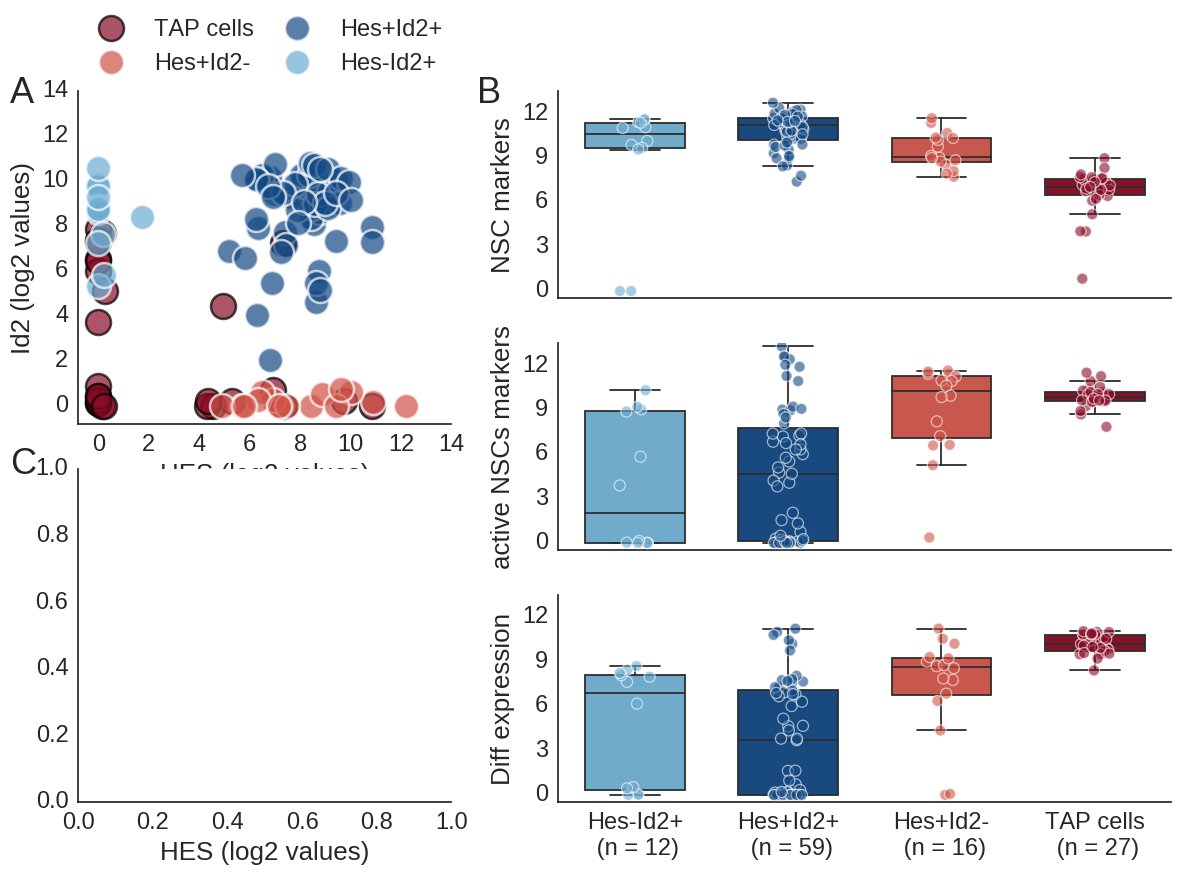

In [6]:
cmap=cm.get_cmap('RdBu_r')
f = plt.subplots(6, 5, figsize=(12, 8), sharex=True)
plt.tight_layout()
plt.subplots_adjust(wspace=0.8)
ax = plt.subplot2grid((6, 5), (0, 0), colspan=2, rowspan=3)
ax.text(-3.5, 13.5, 'A', fontsize=26)
ax.text(15.0, 13.5, 'B', fontsize=26)
ax.text(-3.5, -3.0, 'C', fontsize=26)

D['list_genes'] = gname(Xi,[l['Hes'], ['Id2'], l['NSC'], l['aNSC'], l['Diff']])
x = get_expression(D)

tr = 2    
t = [(x[0] < tr) & (x[1] > tr) & (D['marker']=='o'), (x[0] > tr) & (x[1] > tr) & (D['marker']=='o'), 
     (x[0] > tr) & (x[1] < tr) & (D['marker']=='o'), (D['marker']!='o')]
m     = ['o','o','o','o']
mec   = ['w','w','w','k']
c     = [cmap(0.25), cmap(0.05), cmap(0.82), cmap(0.95), 'y']
label = ['Hes-Id2+','Hes+Id2+','Hes+Id2-', 'TAP cells']

for i in np.arange(len(t)-1, -1, -1):
    plt.plot(x[0][t[i]], x[1][t[i]], marker=m[i], color=c[i], lw=0.0, mew=1.8, 
             mec=mec[i], ms=18, alpha=0.7, label=label[i])
    
print 'number of TAP with Hes>2 = ', np.sum(x[0][t[3]]>tr)
ax.set_xlabel('HES (log2 values)')
ax.set_ylabel('Id2 (log2 values)')
ax.set_xlim([-0.8,14])
ax.set_ylim([-0.8,14])
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)

ax = plt.subplot2grid((6, 5), (3, 0), colspan=2, rowspan=3)
ax.set_xlabel('HES (log2 values)')
ylim = [[-0.5,13.5], [-0.5,13.5], [-0.5,13.5]]
ylabel = ['NSC markers', 'active NSCs markers', 'Diff expression']
for i in range(3):
    ax = plt.subplot2grid((6, 5), (2*i, 2), colspan=3, rowspan=2)
    sns.boxplot(  data=[x[2+i][t[j]] for j in range(4)], palette=c, ax=ax,
                  saturation=0.9, width=0.65, fliersize=0)
    sns.stripplot(data=[x[2+i][t[j]] for j in range(4)], jitter=True, palette=c, size=8,
                  linewidth=0.9, edgecolor='w', marker='o', ax=ax, alpha=0.6)
    ax.set_xticks([0, 1, 2, 3])
    if i==2:
        ax.set_xticklabels([label[j]+'\n (n = '+str(np.sum(t[j]))+')' for j in range(4)])
    else:
        ax.set_xticklabels([])        
    ax.set_yticks([0, 3, 6, 9, 12])
    ax.set_ylabel(ylabel[i])
    ax.set_ylim(ylim[i])
sns.despine()
#plt.savefig('../figures/Figure5_AdultBrain_v2.pdf', format='pdf', dpi=200)